In [1]:
! pip install faiss-cpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.0/27.0 MB 23.1 MB/s eta 0:00:00


In [2]:
import numpy as np
from scipy import spatial
import faiss
import typing
from time import time
import matplotlib.pyplot as plt

## Helper Function

In [3]:
def generate_vectors(
        num_vectors: int,
        dim: int,
        distribution: str,
        seed: int = 42,
) -> np.ndarray:
    """
    This function generates random vectors of uniform distribution.
    Args:
        num_vectors: The number of vectors to generate.
        dim: The dimensionality of the vectors.
        seed: The random seed.
    Returns:
        An array of shape (num_vectors, dim) containing the generated vectors.
    """
    np.random.seed(seed)
    return np.random.uniform(0, 1, (num_vectors, dim))

In [4]:
def naive_exhaustive_search(
        query_vectors: np.ndarray,
        index_vectors: np.ndarray,
        k: int,
) -> np.ndarray:
    """
    This function computes the k-nearest neighbors of query_vectors in index_vectors using the naive exhaustive approach.
    Args:
        query_vectors: An array of shape (n_queries, dim) containing the query vectors.
        index_vectors: An array of shape (n_index, dim) containing the index vectors.
        k: The number of nearest neighbors to retrieve.
    Returns:
        An array of shape (n_queries, k) containing the indices of the k-nearest neighbors for each query vector.
    """
    all_distances = []
    for query_vector in query_vectors:
        query_distances = []
        for index_vector in index_vectors:
            query_distances.append(spatial.distance.euclidean(query_vector, index_vector))
        all_distances.append(np.argsort(query_distances)[:k])
    return np.array(all_distances)

In [5]:
def optimized_exhaustive_search(
        query_vectors: np.ndarray,
        index_vectors: np.ndarray,
        k: int,
):
    """
    This function computes the k-nearest neighbors of query_vectors in index_vectors using the optimized exhaustive approach implemented in SciPy.
    Args:
        query_vectors: An array of shape (n_queries, dim) containing the query vectors.
        index_vectors: An array of shape (n_index, dim) containing the index vectors.
        k: The number of nearest neighbors to retrieve.
    Returns:
        An array of shape (n_queries, k) containing the indices of the k-nearest neighbors for each query vector.
    """
    distances = spatial.distance.cdist(query_vectors, index_vectors, 'euclidean')
    return np.argsort(distances, axis=1)[:, :k]

In [6]:
def build_faiss_flatl2_index(
        index_vectors: np.ndarray,
        dim: int,
):
    """
    This function builds a Faiss flat L2 index.
    Args:
        index_vectors: An array of shape (n_index, dim) containing the index vectors.
        dim: The dimensionality of the vectors.
    Returns:
        A Faiss flat L2 index.
    """
    index = faiss.IndexFlatL2(dim)
    index.add(index_vectors)
    return index

In [7]:
def faiss_search(
        query_vectors: np.ndarray,
        index: faiss.Index,
        k: int,
):
    """
    This function uses a Faiss index to search for the k-nearest neighbors of query_vectors.
    Args:
        query_vectors: An array of shape (n_queries, dim) containing the query vectors.
        index: A Faiss index.
        k: The number of nearest neighbors to retrieve.
    Returns:
        An array of shape (n_queries, k) containing the indices of the k-nearest neighbors for each query vector.
    """
    distances, indices = index.search(query_vectors, k)
    return indices

In [8]:
def build_faiss_lsh_index(
        index_vectors: np.ndarray,
        dim: int,
        nbits: int,
):
    """
    This function builds a Faiss LSH index.
    Args:
        index_vectors: An array of shape (n_index, dim) containing the index vectors.
        dim: The dimensionality of the vectors.
        nbits: The number of bits to use in the hash.
    Returns:
        A Faiss LSH index.
    """
    index = faiss.IndexLSH(dim, nbits)
    index.add(index_vectors)
    return index

In [9]:
def compute_recall_at_k(
        nn_gt: np.ndarray,
        ann: np.ndarray,
        k: int,
):
    """
    This function computes the recall@k.
    Args:
        nn_gt: The ground truth nearest neighbors.
        ann: The approximate nearest neighbors.
        k: The number of nearest neighbors to consider.
    Returns:
        The recall@k.
    """
    return round(sum([len(set(ann[i]) & set(nn_gt[i])) / k for i in range(len(ann))])/len(ann), 3)

# 1.1 - Running Time Comparison

You are given three methods for vector search:
<ol>
 <li> naive_exhaustive_search </li>
 <li> optimized_exhaustive_search </li>
 <li> faiss_flatL2 </li>
</ol>

each one implements vector search with different levels of optimization. Your task is to compare the running time of these three methods.
You need to complete the code so that the generated plots should reflect the increasing difference in running time between the methods, as a function of the desired parameters.
The plots should be clear and self-explanatory, including the labels, title, and legend.
There is no need to experiment with long running times (few seconds are enough for each plot); just ensure that the trends are visible.
You are allowed to add more cells between the TODOs, but do not flip the order of the subsections.
When you finish. do not forget to attach the plots to report.pdf, placed under a clear title indicating the section number.

### Generate the following plots:
##### 1.1.1. Running time of the three methods as a function of the number of vectors in the index (x-axis) with the following parameters fixed:
* vector dimensionality: 100
* number of vectors in the query set: 1000
##### 1.1.2. Running time of the three methods as a function of the dimensionality of the vectors (x-axis) with the following parameters fixed:
* number of vectors in the index: 100000
* number of vectors in the query set: 1000

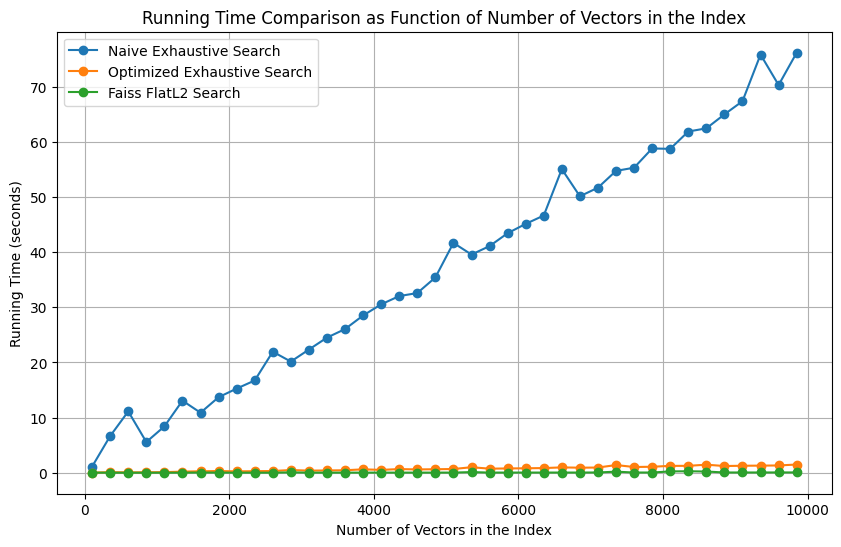

In [15]:
# 1.1.1
# Parameters
vector_dim = 100
num_query_vectors = 1000
k = 10
index_sizes = list(range(100,10000,250))

# Generate query vectors
query_vectors = generate_vectors(num_query_vectors, vector_dim, 'uniform').astype(np.float32)

# To store running times
times_naive = []
times_optimized = []
times_faiss = []

for num_vectors in index_sizes:
    # Generate index vectors
    index_vectors = generate_vectors(num_vectors, vector_dim, 'uniform').astype(np.float32)

    # Naive Exhaustive Search
    start_time = time()
    naive_exhaustive_search(query_vectors, index_vectors, k)
    times_naive.append(time() - start_time)

    # Optimized Exhaustive Search
    start_time = time()
    optimized_exhaustive_search(query_vectors, index_vectors, k)
    times_optimized.append(time() - start_time)

    # Faiss FlatL2 Search
    start_time = time()
    faiss_index = build_faiss_flatl2_index(index_vectors, vector_dim)
    faiss_search(query_vectors, faiss_index, k)
    times_faiss.append(time() - start_time)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(index_sizes, times_naive, label='Naive Exhaustive Search', marker='o')
plt.plot(index_sizes, times_optimized, label='Optimized Exhaustive Search', marker='o')
plt.plot(index_sizes, times_faiss, label='Faiss FlatL2 Search', marker='o')
plt.xlabel('Number of Vectors in the Index')
plt.ylabel('Running Time (seconds)')
plt.title('Running Time Comparison as Function of Number of Vectors in the Index')
plt.legend()
plt.grid(True)
plt.show()

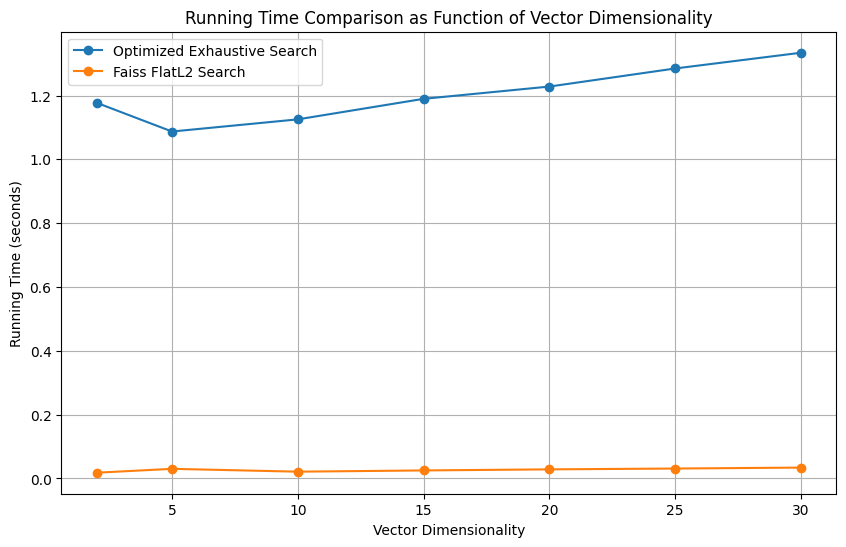

In [11]:
# 1.1.2
# Parameters
num_index_vectors = 100000
num_query_vectors = 100
k = 10
vector_dims = [2, 5, 10, 15, 20, 25, 30]

# Generate index and query vectors
index_vectors = generate_vectors(num_index_vectors, vector_dims[-1], 'uniform').astype(np.float32)
query_vectors = generate_vectors(num_query_vectors, vector_dims[-1], 'uniform').astype(np.float32)

# To store running times
times_naive = []
times_optimized = []
times_faiss = []

for dim in vector_dims:
    # Adjust the vectors to the current dimension
    index_vecs = np.ascontiguousarray(index_vectors[:, :dim])
    query_vecs = np.ascontiguousarray(query_vectors[:, :dim])

    # Optimized Exhaustive Search
    start_time = time()
    optimized_exhaustive_search(query_vecs, index_vecs, k)
    times_optimized.append(time() - start_time)

    # Faiss FlatL2 Search
    start_time = time()
    faiss_index = build_faiss_flatl2_index(index_vecs, dim)
    faiss_search(query_vecs, faiss_index, k)
    times_faiss.append(time() - start_time)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(vector_dims, times_optimized, label='Optimized Exhaustive Search', marker='o')
plt.plot(vector_dims, times_faiss, label='Faiss FlatL2 Search', marker='o')
plt.xlabel('Vector Dimensionality')
plt.ylabel('Running Time (seconds)')
plt.title('Running Time Comparison as Function of Vector Dimensionality')
plt.legend()
plt.grid(True)
plt.show()

# 1.2 -- Faiss LSH
### Create the following plots:
##### 1.2.1. Running time of Faiss LSH as a function of the number of vectors in the index (x-axis) with the following parameters fixed:
* vector dimensionality: 100
* number of vectors in the query set: 1000
* nbits: 500

##### 1.2.2. Running time of Faiss LSH as a function of nbits (x-axis) with the following parameters fixed:
* vector dimensionality: 100
* number of vectors in the query set: 1000
* number of vectors in the index: 500000


##### 1.2.3. recall@k of Faiss LSH as a function of nbits (x-axis) with the following parameters fixed:
* vector dimensionality: 100
* number of vectors in the query set: 1000
* number of vectors in the index: 500000
* k: 10


You need to complete the code so that the generated plots should reflect the desired metrics as a function of the desired parameters.
The plots should be clear and self-explanatory, including the labels, title, and legend.
There is no need to experiment with long running times (few seconds are enough for each plot); just ensure that the trends are visible.
You are allowed to add more cells between the TODOs, but do not flip the order of the subsections.
When you finish. do not forget to attach the plots to report.pdf, placed under a clear title indicating the section number.


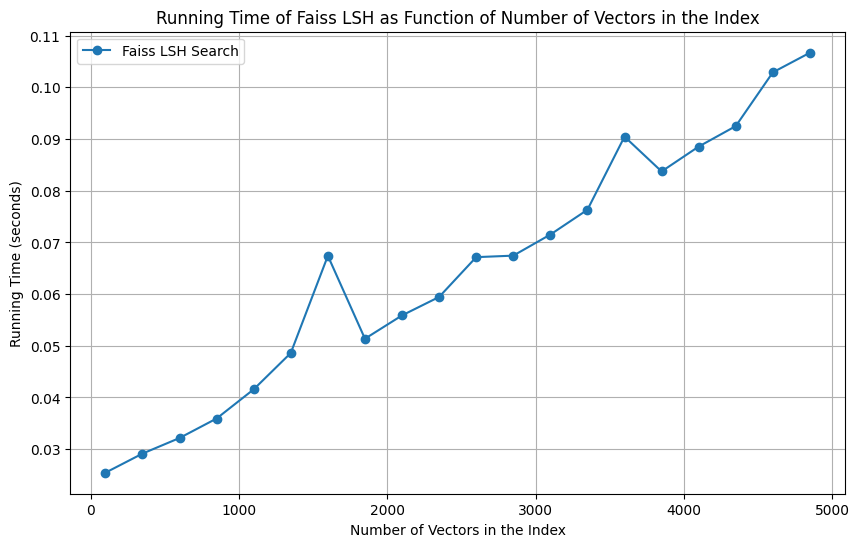

In [17]:
# 1.2.1
# Parameters
vector_dim = 100
num_query_vectors = 1000
nbits = 500
index_sizes = list(range(100,5000,250))

# Generate query vectors
query_vectors = generate_vectors(num_query_vectors, vector_dim, 'uniform').astype(np.float32)

# To store running times
times_faiss_lsh = []

for num_vectors in index_sizes:
    # Generate index vectors
    index_vectors = generate_vectors(num_vectors, vector_dim, 'uniform').astype(np.float32)

    # Faiss LSH Search
    start_time = time()
    faiss_lsh_index = build_faiss_lsh_index(index_vectors, vector_dim, nbits)
    faiss_search(query_vectors, faiss_lsh_index, k)
    times_faiss_lsh.append(time() - start_time)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(index_sizes, times_faiss_lsh, label='Faiss LSH Search', marker='o')
plt.xlabel('Number of Vectors in the Index')
plt.ylabel('Running Time (seconds)')
plt.title('Running Time of Faiss LSH as Function of Number of Vectors in the Index')
plt.legend()
plt.grid(True)
plt.show()

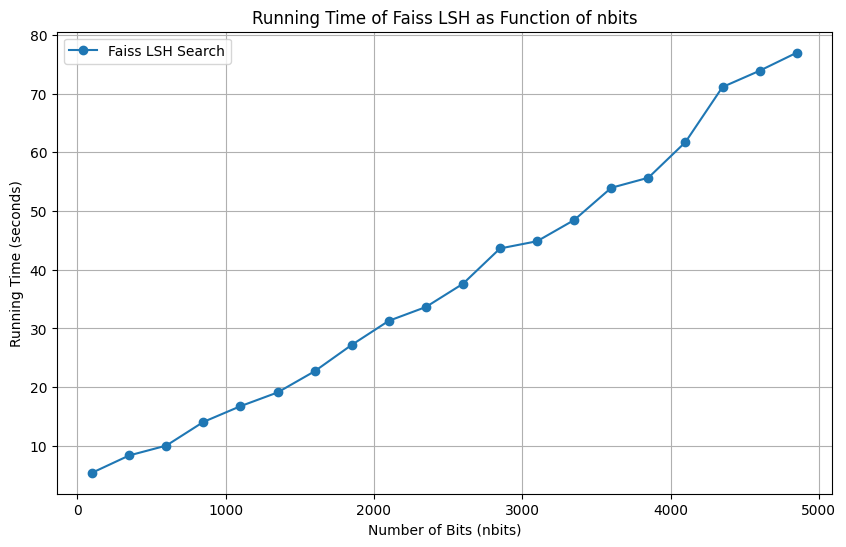

In [13]:
# 1.2.2
# Parameters
vector_dim = 100
num_index_vectors = 500000
num_query_vectors = 1000
nbits_values = list(range(100,5000,250))

# Generate index and query vectors
index_vectors = generate_vectors(num_index_vectors, vector_dim, 'uniform').astype(np.float32)
query_vectors = generate_vectors(num_query_vectors, vector_dim, 'uniform').astype(np.float32)

# To store running times
times_faiss_lsh = []

for nbits in nbits_values:
    # Faiss LSH Search
    start_time = time()
    faiss_lsh_index = build_faiss_lsh_index(index_vectors, vector_dim, nbits)
    faiss_search(query_vectors, faiss_lsh_index, k)
    times_faiss_lsh.append(time() - start_time)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(nbits_values, times_faiss_lsh, label='Faiss LSH Search', marker='o')
plt.xlabel('Number of Bits (nbits)')
plt.ylabel('Running Time (seconds)')
plt.title('Running Time of Faiss LSH as Function of nbits')
plt.legend()
plt.grid(True)
plt.show()

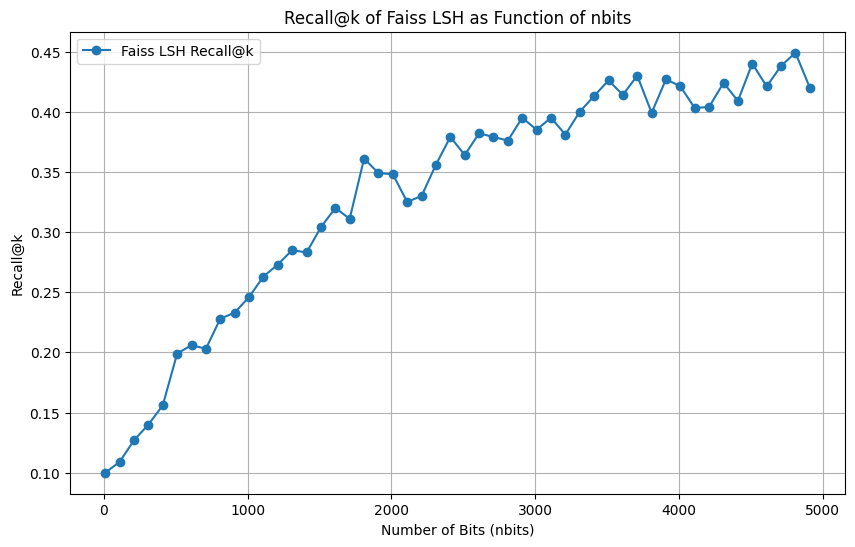

In [14]:
# 1.2.3
# Parameters
vector_dim = 100
num_index_vectors = 100000
num_query_vectors = 100
k = 10
nbits_values = list(range(10,5000,100))

# Generate index and query vectors
index_vectors = generate_vectors(num_index_vectors, vector_dim, 'uniform').astype(np.float32)
query_vectors = generate_vectors(num_query_vectors, vector_dim, 'uniform').astype(np.float32)

# Ground truth using optimized exhaustive search
nn_ground_truth = naive_exhaustive_search(query_vectors, index_vectors, k)

# To store recalls
recalls = []

for nbits in nbits_values:
    # Faiss LSH Search
    faiss_lsh_index = build_faiss_lsh_index(index_vectors, vector_dim, nbits)
    nn_approx = faiss_search(query_vectors, faiss_lsh_index, k)
    recall = compute_recall_at_k(nn_ground_truth, nn_approx, k)
    recalls.append(recall)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(nbits_values, recalls, label='Faiss LSH Recall@k', marker='o')
plt.xlabel('Number of Bits (nbits)')
plt.ylabel('Recall@k')
plt.title('Recall@k of Faiss LSH as Function of nbits')
plt.legend()
plt.grid(True)
plt.show()